In [2]:
import pandas as pd
def load_csv_from_github(file_name):
 base_url = "https://raw.githubusercontent.com/marymorkos/SalesPlaybookDS5640/refs/heads/main/"
 return pd.read_csv(base_url + file_name)

In [4]:
# load in deals merged data for mod
df = load_csv_from_github("deals_centric_merged.csv")
df.head()

,Weighted amount,Deal Description,"Cumulative time in ""BANT Deal. Pain ID'ed (Sales Pipeline)"" (HH:mm:ss)","Cumulative time in ""Opportunity (Sales Pipeline)"" (HH:mm:ss)",Days to close,Deal Score,Close Date,Deal source attribution 2,"Cumulative time in ""In Trial - Trial in Progress (Sales Pipeline)"" (HH:mm:ss)",Contract Start Date,...,Latest Milestone Update Date,Ticket name,Trial Overview,Trial Start Date,1st Syms presented for review,Project Launch Day,Training: Reporting,Construction of 1st Sym begun,Trial Required,Was the sym QAed?
0,250.0,40-50 employees,NaN,NaN,69.0,33.0,2025-05-01 15:26,Event,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.0,"3,000 + Agents.",NaN,NaN,149.0,13.0,2025-07-20 09:06,Referral Partner,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.0,5-6k agents,NaN,NaN,149.0,13.0,2025-07-20 09:03,Referral Partner,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.0,Furthest Along - 300 agents,NaN,NaN,149.0,13.0,2025-07-20 08:55,Referral Partner,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,10000.0,BPO through partnership with AmplifAI,NaN,NaN,120.0,37.0,2025-06-20 15:01,Master Agent,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
# Calculate percentage of missing values in each column
missing_percentage = df.isna().mean()

# Find columns with less than 70% missing values 
columns_to_keep = missing_percentage[missing_percentage < 0.7].index

# Create a new dataframe with only the columns to keep
df_cleaned = df[columns_to_keep]

In [6]:
# Identify columns with 30-70% missing values
columns_30_70_missing = missing_percentage[(missing_percentage >= 0.3) & (missing_percentage <= 0.7)]

# Print the columns and their missing percentages
print("Columns with 30-70% missing values:")
for column, percent in columns_30_70_missing.items():
    print(f"{column}: {percent:.2%} missing")


Columns with 30-70% missing values:
Cumulative time in "BANT Deal. Pain ID'ed (Sales Pipeline)" (HH:mm:ss): 64.76% missing
Last Activity Date: 32.21% missing
Close Date_company: 54.81% missing
ICP Fit Level: 42.66% missing
Segmentation: 63.91% missing
Type: 32.38% missing
Primary Sub-Industry: 45.87% missing


In [7]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OrdinalEncoder
import re

def impute_sales_data(df, high_missing_threshold=0.3):
    """
    Efficient imputation pipeline for CRM sales data, handling both 
    high-missing-rate columns (30-70%) and low-missing-rate columns (<30%).
    
    Parameters:
    df (pandas.DataFrame): Input dataframe with missing values
    high_missing_threshold (float): Threshold to determine which columns need advanced imputation
    
    Returns:
    pandas.DataFrame: DataFrame with all missing values imputed
    """
    print("Starting imputation pipeline...")
    result_df = df.copy()
    
    # Check if there are any missing values at all
    if not df.isna().any().any():
        print("No missing values found in dataset. No imputation needed.")
        return result_df
    
    # Classify columns by data type once for the whole process
    date_cols = [col for col in df.columns if 'Date' in col or 'date' in col]
    # Expanded time column detection
    time_cols = [col for col in df.columns if any(term in col.lower() for term in 
                ['time', 'HH:mm', 'duration', 'hours', 'minutes'])]
    
    # Special case for the known cumulative time column
    known_time_col = 'Cumulative time in "BANT Deal. Pain ID\'ed (Sales Pipeline)" (HH:mm:ss)'
    if known_time_col in df.columns and known_time_col not in time_cols:
        time_cols.append(known_time_col)
    
    # Ensure columns are unique across categories
    categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
    categorical_cols = [col for col in categorical_cols if col not in date_cols and col not in time_cols]
    numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
    
    # Identify high-missing and low-missing columns
    missing_rates = df.isna().mean()
    high_missing_cols = missing_rates[missing_rates >= high_missing_threshold].index.tolist()
    
    print(f"Identified column types: {len(date_cols)} date columns, {len(time_cols)} time columns, "
          f"{len(categorical_cols)} categorical columns, {len(numeric_cols)} numeric columns")
    print(f"Found {len(high_missing_cols)} columns with high missing rates (≥{high_missing_threshold*100}%)")
    
    # Process each column type with the appropriate method
    print("Processing date columns...")
    result_df = process_date_columns(result_df, date_cols, high_missing_cols, high_missing_threshold)
    
    print("Processing time columns...")
    result_df = process_time_columns(result_df, time_cols, high_missing_cols)
    
    print("Processing categorical columns...")
    result_df = process_categorical_columns(result_df, categorical_cols, high_missing_cols)
    
    print("Processing numeric columns...")
    result_df = process_numeric_columns(result_df, numeric_cols, high_missing_cols, high_missing_threshold)
    
    # Verify no NaN values remain
    remaining_nans = result_df.isna().sum()
    columns_with_nans = remaining_nans[remaining_nans > 0]
    
    if not columns_with_nans.empty:
        print(f"Warning: {len(columns_with_nans)} columns still have missing values after imputation:")
        for col, count in columns_with_nans.items():
            print(f"  - {col}: {count} missing values")
        print("Performing final cleanup...")
        
        # Final fallback for any remaining NaN values
        for col in columns_with_nans.index:
            dtype = result_df[col].dtype
            if pd.api.types.is_numeric_dtype(dtype):
                result_df[col] = result_df[col].fillna(0)
            elif pd.api.types.is_datetime64_dtype(dtype):
                result_df[col] = result_df[col].fillna(pd.Timestamp('2020-01-01'))
            else:
                result_df[col] = result_df[col].fillna('Unknown')
    
    print("Imputation complete!")
    return result_df

def process_date_columns(df, date_cols, high_missing_cols, threshold):
    """Handle date columns based on their missing rate"""
    result_df = df.copy()
    
    for col in date_cols:
        if col not in df.columns or not df[col].isna().any():
            continue
        
        # Create a copy of the original column in case conversion fails
        original_values = result_df[col].copy()
        
        try:
            # Convert to datetime
            result_df[col] = pd.to_datetime(result_df[col], errors='coerce')
            
            # Check if conversion was successful
            if result_df[col].isna().all():
                print(f"Warning: Could not convert column {col} to datetime. Using original values.")
                result_df[col] = original_values
                continue
            
            if col in high_missing_cols:
                # For high missing rates, use a reference date and simple imputation
                reference_date = pd.Timestamp('2020-01-01')
                
                # For datetimes, use median of available dates
                valid_dates = result_df[col].dropna()
                if not valid_dates.empty:
                    median_date = valid_dates.median()
                    result_df[col] = result_df[col].fillna(median_date)
                else:
                    # If all dates are missing, use reference date
                    result_df[col] = result_df[col].fillna(reference_date)
            else:
                # For low missing rates, use forward/backward fill or most frequent
                missing_pct = df[col].isna().mean()
                if missing_pct > 0.05:  # More than 5% missing
                    # First try to sort by a related date column if possible
                    date_cols_sorted = sorted(date_cols, key=lambda x: df[x].isna().mean())
                    for sort_col in date_cols_sorted:
                        if sort_col != col and not df[sort_col].isna().all() and pd.api.types.is_datetime64_dtype(result_df[sort_col]):
                            try:
                                # Try sorting by this column to improve ffill/bfill
                                temp_df = result_df[[sort_col, col]].sort_values(sort_col)
                                temp_df[col] = temp_df[col].ffill().bfill()
                                result_df[col] = temp_df[col]
                                break
                            except:
                                continue
                    
                    # If no sorting worked, just fill without sorting
                    if result_df[col].isna().any():
                        result_df[col] = result_df[col].ffill().bfill()
                else:
                    # For very low missing rates, use most frequent date
                    most_freq_date = result_df[col].mode()[0]
                    result_df[col] = result_df[col].fillna(most_freq_date)
            
            # Convert back to original string format if needed
            if df[col].dtype == 'object':
                try:
                    has_time = original_values.astype(str).str.contains(':').any()
                    format_str = '%m/%d/%Y %H:%M' if has_time else '%m/%d/%Y'
                    result_df[col] = result_df[col].dt.strftime(format_str)
                except:
                    # If datetime formatting fails, keep as is
                    print(f"Warning: Could not format dates in {col} back to string. Keeping datetime format.")
        except Exception as e:
            print(f"Error processing date column {col}: {e}")
            # Restore original values if processing failed
            result_df[col] = original_values
    
    return result_df

def process_time_columns(df, time_cols, high_missing_cols):
    """Handle time columns (HH:MM:SS format)"""
    result_df = df.copy()
    
    for col in time_cols:
        if col not in df.columns or not df[col].isna().any():
            continue
        
        try:
            # Keep original values in case of error
            original_values = result_df[col].copy()
            
            # Convert time to seconds for processing, with error handling
            try:
                result_df[f'{col}_seconds'] = df[col].apply(
                    lambda x: sum(int(t) * m for t, m in zip(x.split(':'), [3600, 60, 1])) 
                    if isinstance(x, str) and re.match(r'\d+:\d+:\d+', x) else np.nan
                )
            except Exception as e:
                print(f"Warning: Error converting time column {col} to seconds: {e}")
                continue
            
            # Check if conversion was successful
            if result_df[f'{col}_seconds'].isna().all():
                print(f"Warning: Could not convert any values in {col} to seconds. Skipping.")
                # Clean up and continue to next column
                if f'{col}_seconds' in result_df.columns:
                    result_df = result_df.drop(columns=[f'{col}_seconds'])
                continue
            
            # For any column, use median imputation (simple and effective for time)
            median_seconds = result_df[f'{col}_seconds'].median()
            if pd.isna(median_seconds):  # If median is NaN, use 0
                median_seconds = 0
            
            result_df[f'{col}_seconds'] = result_df[f'{col}_seconds'].fillna(median_seconds)
            
            # Convert seconds back to HH:MM:SS format
            try:
                result_df[col] = result_df[f'{col}_seconds'].apply(
                    lambda x: f"{int(x // 3600):d}:{int((x % 3600) // 60):02d}:{int(x % 60):02d}" 
                    if not pd.isna(x) else ""
                )
            except Exception as e:
                print(f"Warning: Error converting seconds back to time format for {col}: {e}")
                result_df[col] = original_values
            
            # Drop the temporary seconds column
            if f'{col}_seconds' in result_df.columns:
                result_df = result_df.drop(columns=[f'{col}_seconds'])
                
        except Exception as e:
            print(f"Error processing time column {col}: {e}")
            # Make sure column still exists in result_df
            if col not in result_df.columns:
                result_df[col] = original_values
    
    return result_df

def process_categorical_columns(df, categorical_cols, high_missing_cols):
    """Handle categorical columns"""
    result_df = df.copy()
    
    # Handle industry columns as a special case for consistency
    industry_cols = [col for col in categorical_cols if 'Industry' in col]
    if len(industry_cols) > 1:
        # Try to fill missing values from other industry columns first
        for i, col1 in enumerate(industry_cols):
            for col2 in industry_cols[i+1:]:
                # Where col1 is null but col2 isn't, copy from col2
                mask = df[col1].isna() & df[col2].notna()
                result_df.loc[mask, col1] = df.loc[mask, col2]
                
                # And vice versa
                mask = df[col2].isna() & df[col1].notna()
                result_df.loc[mask, col2] = df.loc[mask, col1]
    
    # Now process remaining categorical columns
    for col in categorical_cols:
        if col not in df.columns or not df[col].isna().any():
            continue
            
        if col in high_missing_cols:
            # For high missing rates, determine approach based on cardinality
            unique_count = df[col].nunique()
            
            if unique_count > 10:
                # Many categories - mark as "Unknown"
                result_df[col] = result_df[col].fillna('Unknown')
            else:
                # Few categories - use most frequent value
                most_freq = df[col].mode()[0]
                result_df[col] = result_df[col].fillna(most_freq)
        else:
            # For low missing rates, use most frequent
            most_freq = df[col].mode()[0]
            result_df[col] = result_df[col].fillna(most_freq)
    
    return result_df

def process_numeric_columns(df, numeric_cols, high_missing_cols, threshold):
    """Handle numeric columns"""
    result_df = df.copy()
    
    # Split financial columns vs other numeric
    financial_cols = [col for col in numeric_cols if any(term in col.lower() for term in 
                    ['amount', 'revenue', 'forecast', 'weighted'])]
    other_numeric = [col for col in numeric_cols if col not in financial_cols]
    
    # Process financial columns
    for col in financial_cols:
        if col not in df.columns or not df[col].isna().any():
            continue
            
        # Use median for financial columns regardless of missing rate
        # (simpler and often effective for financial data)
        median_val = df[col].median()
        result_df[col] = result_df[col].fillna(median_val)
    
    # Group remaining numeric columns by missing rate
    high_missing_numeric = [col for col in other_numeric if col in high_missing_cols]
    low_missing_numeric = [col for col in other_numeric if col not in high_missing_cols]
    
    # For high missing numeric, use MICE if there are multiple columns, otherwise use median
    if high_missing_numeric:
        # Filter to columns that actually have missing values
        cols_with_missing = [col for col in high_missing_numeric if df[col].isna().any()]
        
        if len(cols_with_missing) > 1:  # Multiple columns - use MICE
            imputer = IterativeImputer(
                estimator=RandomForestRegressor(n_estimators=50, max_depth=10, random_state=42),
                max_iter=5,  # Reduced iterations
                random_state=42,
                skip_complete=True
            )
            
            # Get only rows where at least one column has a value (not all missing)
            valid_rows = df[cols_with_missing].notna().any(axis=1)
            
            if valid_rows.any():
                # Create temporary dataframe with only columns to impute
                temp_df = df.loc[valid_rows, cols_with_missing].copy()
                
                # Apply imputation
                imputed_values = imputer.fit_transform(temp_df)
                
                # Update result dataframe for these columns and rows
                for i, col in enumerate(cols_with_missing):
                    result_df.loc[valid_rows, col] = imputed_values[:, i]
                
                # For remaining rows, use median
                for col in cols_with_missing:
                    result_df[col] = result_df[col].fillna(df[col].median())
            else:
                # If all rows are completely missing, use median
                for col in cols_with_missing:
                    result_df[col] = result_df[col].fillna(0)  # Default to 0
        else:
            # Single column - use median (faster and simpler)
            for col in cols_with_missing:
                result_df[col] = result_df[col].fillna(df[col].median())
    
    # For low missing numeric, use simple median imputation
    if low_missing_numeric:
        cols_with_missing = [col for col in low_missing_numeric if df[col].isna().any()]
        
        for col in cols_with_missing:
            result_df[col] = result_df[col].fillna(df[col].median())
    
    # Special case: web analytics columns should be 0 if missing
    web_cols = [col for col in numeric_cols if any(term in col for term in 
                ['Pageviews', 'Sessions', 'Submissions', 'contacted'])]
    
    for col in web_cols:
        if col in result_df.columns and result_df[col].isna().any():
            result_df[col] = result_df[col].fillna(0)
    
    return result_df
df_imputed = impute_sales_data(df_cleaned)

Starting imputation pipeline...
Identified column types: 8 date columns, 3 time columns, 23 categorical columns, 19 numeric columns
Found 7 columns with high missing rates (≥30.0%)
Processing date columns...
Processing time columns...
Processing categorical columns...
Processing numeric columns...
  - Time Zone: 36 missing values
  - Consolidated Industry: 22 missing values
Performing final cleanup...
Imputation complete!


C:\Users\laura\AppData\Local\Temp\ipykernel_32964\1179323607.py:103: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  result_df[col] = pd.to_datetime(result_df[col], errors='coerce')


In [8]:
df_imputed.columns.tolist()

['Weighted amount',
 'Deal Description',
 'Cumulative time in "BANT Deal. Pain ID\'ed (Sales Pipeline)" (HH:mm:ss)',
 'Days to close',
 'Close Date',
 'Deal source attribution 2',
 'Pipeline',
 'Record ID',
 'Forecast category',
 'Original Traffic Source',
 'Associated Company',
 'Deal owner',
 'Is Closed (numeric)',
 'Amount in company currency',
 'Deal probability',
 'Associated Company (Primary)',
 'Is Closed Won',
 'Last Activity Date',
 'Is closed lost',
 'Weighted amount in company currency',
 'Is Deal Closed?',
 'Deal Name',
 'Amount',
 'Forecast amount',
 'Is Open (numeric)',
 'Create Date',
 'Last Modified Date',
 'Deal Stage',
 'Deal Type',
 'Company ID',
 'Annual Revenue',
 'Associated Contact',
 'Number of Form Submissions',
 'Web Technologies',
 'Close Date_company',
 'Number of times contacted',
 'Contact with Primary Company',
 'ICP Fit Level',
 'Record ID_company',
 'Time Zone',
 'Primary Industry',
 'Number of Pageviews',
 'Year Founded',
 'Segmentation',
 'State/Regio

In [9]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, 
    precision_score, 
    recall_score, 
    f1_score, 
    confusion_matrix, 
    classification_report,
    roc_auc_score,
)
from sklearn.ensemble import GradientBoostingClassifier
import matplotlib.pyplot as plt
import time

# SMOTE for handling class imbalance
from imblearn.over_sampling import SMOTE

def prepare_features(df):
    # Columns to exclude - including potentially leaky features
    exclude_columns = [
        'Is Closed Won',  # Target variable
        'Is Closed (numeric)',
        'Is closed lost',
        'Is Deal Closed?',
        'Record ID',
        'Record ID_company',
        'Close Date',
        'Last Modified Date',
        'Create Date',
        'Deal Name',
        'Company name',
        'Deal probability',  # Potential leakage
        'Weighted amount',  # Derived from probability
        'Weighted amount in company currency'  # Also likely leaky
    ]

    # Features for consideration
    candidate_features = [
        # Business Context
        'Days to close',
        'Number of Pageviews',
        'Number of Form Submissions',
        'Number of Sessions',
        'Number of times contacted',
        
        # Financial Indicators
        'Forecast amount',
        'Amount',
        'Amount in company currency',
        'Annual Revenue',
        
        # Company Attributes
        'ICP Fit Level',
        'Industry',
        'Primary Industry',
        'Number of Employees',
        'Year Founded',
        
        # Engagement Metrics
        'Deal source attribution 2',
        'Original Traffic Source',
        'Pipeline',
        'Deal Type',
        'Segmentation'
    ]

    # Filter and prepare features
    features = [col for col in candidate_features if col in df.columns]
    
    # Prepare data
    X = df[features]
    y = df['Is Closed Won']

    # One-hot encode categorical columns
    categorical_cols = X.select_dtypes(include=['object', 'category']).columns
    X = pd.get_dummies(X, columns=categorical_cols)

    # Ensure target is numeric
    if y.dtype == 'object' or y.dtype == 'bool':
        y = y.map({True: 1, 'True': 1, False: 0, 'False': 0})

    return X, y

# Print target distribution
print("Target Variable Distribution:")
print(df_imputed['Is Closed Won'].value_counts(normalize=True))

# Prepare the data
X, y = prepare_features(df_imputed)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Apply SMOTE to training data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Print class distribution after SMOTE
print("\nClass distribution after SMOTE:")
unique, counts = np.unique(y_train_resampled, return_counts=True)
print(dict(zip(unique, counts)))

# Define the parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'subsample': [0.8, 0.9, 1.0]
}

# Create the GridSearchCV object with stratified k-fold cross-validation
print("\n=== Starting Grid Search for Gradient Boosting ===")
start_time = time.time()

grid_search = GridSearchCV(
    estimator=GradientBoostingClassifier(random_state=42),
    param_grid=param_grid,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring='f1',
    n_jobs=-1,  # Use all available cores
    verbose=1
)

# Fit grid search to the resampled training data
grid_search.fit(X_train_resampled, y_train_resampled)

# Time taken
elapsed_time = time.time() - start_time
print(f"\nGrid search completed in {elapsed_time:.2f} seconds")

# Print best parameters
print("\nBest Parameters:")
print(grid_search.best_params_)
print(f"Best F1 Score: {grid_search.best_score_:.4f}")

# Get the best model
best_gb = grid_search.best_estimator_

# Predict with the best model
y_pred = best_gb.predict(X_test)
y_pred_proba = best_gb.predict_proba(X_test)[:, 1]

# Evaluation
print("\nBest Model Performance:")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nAdditional Metrics:")
print(f"ROC AUC Score: {roc_auc_score(y_test, y_pred_proba):.4f}")

# Feature Importance
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': best_gb.feature_importances_
})

# Display top features
print("\nFeature Importance (sorted):")
print(feature_importance.sort_values('importance', ascending=False).head(10))

Target Variable Distribution:
Is Closed Won
False    0.733558
True     0.266442
Name: proportion, dtype: float64

Class distribution after SMOTE:
{0: 348, 1: 348}

=== Starting Grid Search for Gradient Boosting ===
Fitting 5 folds for each of 972 candidates, totalling 4860 fits

Grid search completed in 364.90 seconds

Best Parameters:
{'learning_rate': 0.2, 'max_depth': 4, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 50, 'subsample': 1.0}
Best F1 Score: 0.8825

Best Model Performance:
Confusion Matrix:
[[77 10]
 [ 8 24]]

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.89      0.90        87
           1       0.71      0.75      0.73        32

    accuracy                           0.85       119
   macro avg       0.81      0.82      0.81       119
weighted avg       0.85      0.85      0.85       119


Additional Metrics:
ROC AUC Score: 0.9019

Feature Importance (sorted):
                             

In [10]:
print("\nFeature Importance (top 15):")
print(feature_importance.sort_values('importance', ascending=False).head(15))


Feature Importance (top 15):
                                        feature  importance
1                           Number of Pageviews    0.199837
5                               Forecast amount    0.096498
6                                        Amount    0.090966
157                           Deal Type_Renewal    0.053904
4                     Number of times contacted    0.053748
3                            Number of Sessions    0.052086
2                    Number of Form Submissions    0.047116
145  Deal source attribution 2_SymTrain EE name    0.039818
10                                 Year Founded    0.033500
9                           Number of Employees    0.033017
0                                 Days to close    0.032796
156                                Deal Type_PS    0.030559
44              Industry_Hospital & Health Care    0.029861
154                            Deal Type_Growth    0.029360
7                    Amount in company currency    0.022837


In [ ]:
companies_df = load_csv_from_github("anonymized_hubspot_companies.csv")

# Print original DataFrame shape
print("Original DataFrame shape:", companies_df.shape)

# Remove columns with more than 40% missing values
missing_percentages = companies_df.isnull().mean()
columns_to_drop = missing_percentages[missing_percentages > 0.4].index
companies_df = companies_df.drop(columns=columns_to_drop)

# Print shape after dropping columns
print("DataFrame shape after dropping columns:", companies_df.shape)

# Drop rows with any missing values
companies_df = companies_df.dropna()

# Print final DataFrame shape
print("Final DataFrame shape after dropping rows:", companies_df.shape)

Original DataFrame shape: (19851, 46)
DataFrame shape after dropping columns: (19851, 18)
Final DataFrame shape after dropping rows: (14217, 18)


In [27]:
companies_df.columns.tolist()

['Annual Revenue',
 'Associated Contact',
 'Number of Form Submissions',
 'Web Technologies',
 'Contact with Primary Company',
 'Record ID',
 'Time Zone',
 'Number of Pageviews',
 'Year Founded',
 'State/Region',
 'Consolidated Industry',
 'Number of Employees',
 'Number of Sessions',
 'Country/Region',
 'Industry',
 'Create Date',
 'Company name',
 'Last Modified Date']

In [13]:
companies_df.columns.tolist()
# Categorical columns to analyze
categorical_features = [
    'Web Technologies', 
    'Time Zone', 
    'State/Region', 
    'Consolidated Industry', 
    'Country/Region', 
    'Industry'
]

# Count unique categories and print
print("Unique Categories Count:")
for column in categorical_features:
    unique_count = companies_df[column].nunique()
    print(f"{column}: {unique_count} unique categories")

Unique Categories Count:
Web Technologies: 13446 unique categories
Time Zone: 161 unique categories
State/Region: 608 unique categories
Consolidated Industry: 73 unique categories
Country/Region: 121 unique categories
Industry: 171 unique categories


Starting mixed data clustering...
Processing Industry data...
Processing Web Technologies data...
Processing Country/Region data...
Processing numeric features...
Creating dummy variables for: ['Industry_Group', 'Tech_Group', 'Region_Group']
Using 22 dummy variables after filtering rare categories
Combining numeric and categorical features...
Final feature matrix shape: (14217, 28)
Applying PCA for dimensionality reduction...
PCA explained variance: 0.92
Applying K-means with 5 clusters...

Cluster Statistics:
Cluster 0: 2025 companies (14.2%)
Cluster 1: 7 companies (0.0%)
Cluster 2: 9460 companies (66.5%)
Cluster 3: 2658 companies (18.7%)
Cluster 4: 67 companies (0.5%)
Silhouette score: -0.387


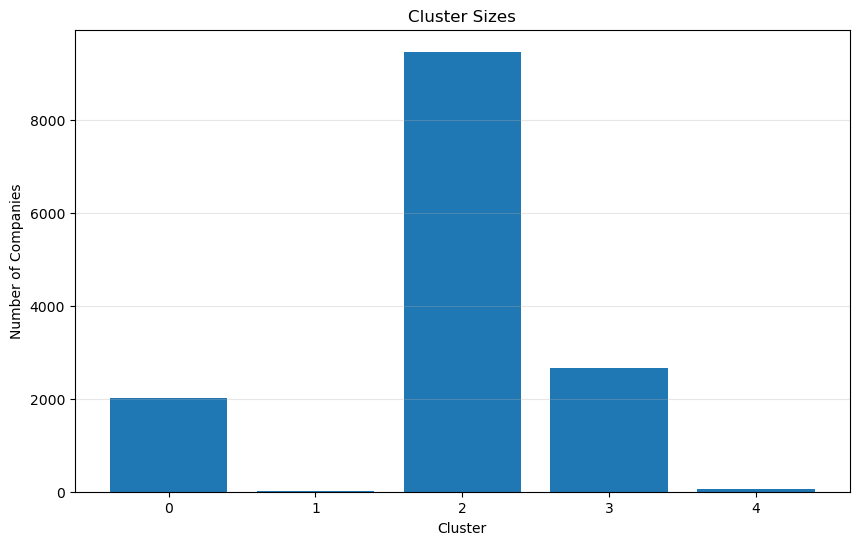


Numeric profiles (median values):
         Annual Revenue  Number of Form Submissions  Number of Pageviews  \
Cluster                                                                    
0          1.000000e+10                         0.0                  0.0   
1          3.768059e+06                        81.0                661.0   
2          5.000000e+07                         0.0                  0.0   
3          1.000000e+08                         0.0                  0.0   
4          1.203760e+08                         0.0                  0.0   

         Year Founded  Number of Employees  Number of Sessions  
Cluster                                                         
0              1980.0              10000.0                 0.0  
1              2006.0               1600.0               319.0  
2              1997.0               1000.0                 0.0  
3              1907.0               5000.0                 0.0  
4              1965.0             357247.0

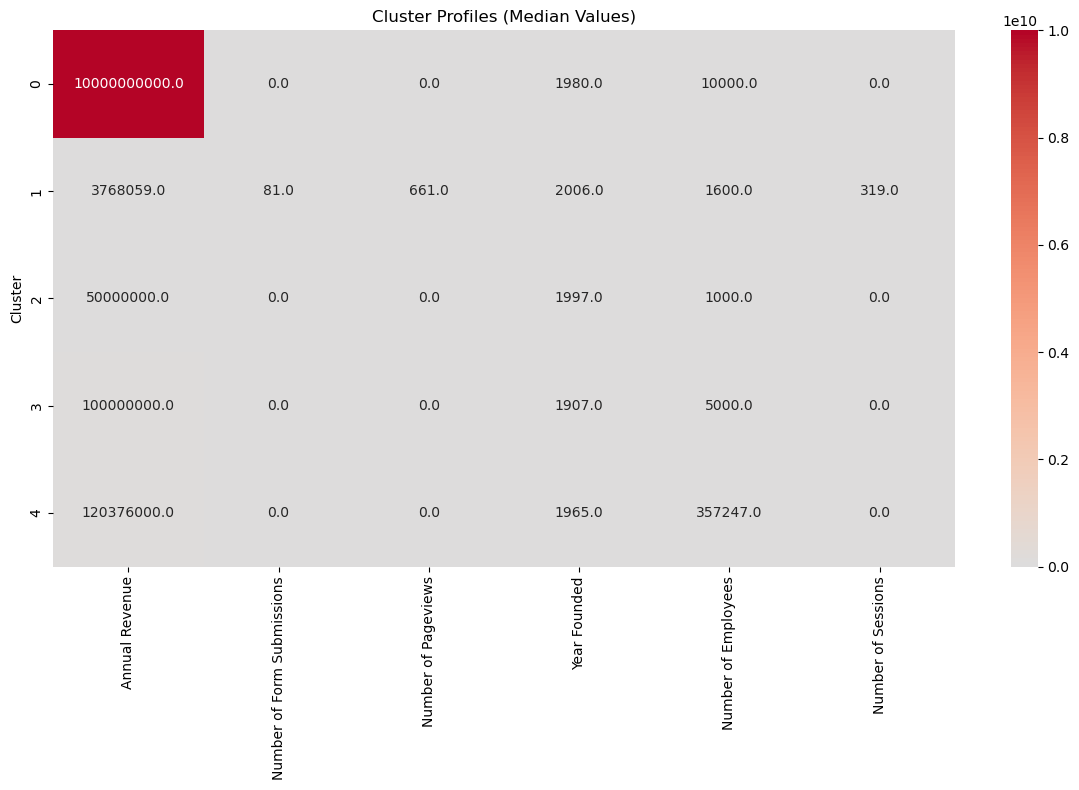


Industry_Group distribution by cluster:
Industry_Group  Education    Energy    Finance  Healthcare  Manufacturing  \
Cluster                                                                     
0                6.962963  2.123457  12.246914    4.197531       7.950617   
1               28.571429  0.000000  14.285714   14.285714       0.000000   
2                9.175476  0.813953  14.608879    3.995772       5.613108   
3               12.979684  1.316780  24.040632    2.633559       8.991723   
4                2.985075  0.000000   2.985075    2.985075       5.970149   

Industry_Group     Media      Other  Real Estate     Retail  Services  \
Cluster                                                                 
0               2.271605  31.061728     3.456790   4.740741  4.000000   
1               0.000000  28.571429     0.000000   0.000000  0.000000   
2               1.723044  23.921776     3.551797   2.780127  7.040169   
3               1.805869  21.068473     2.595937   4.1

<Figure size 1400x800 with 0 Axes>

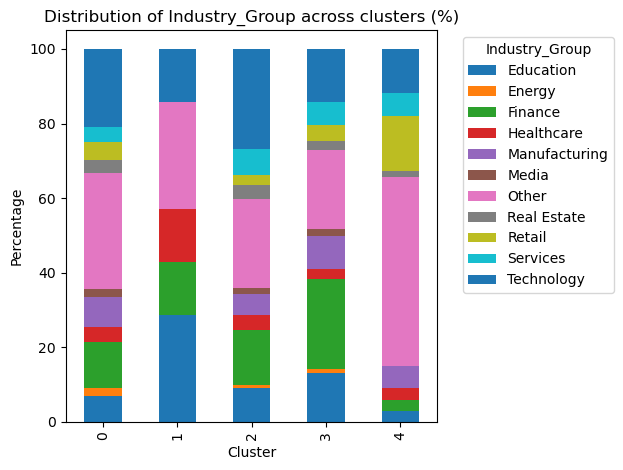


Tech_Group distribution by cluster:
Tech_Group  Advertising  Analytics       CMS  Cloud Services  Development  \
Cluster                                                                     
0              3.061728   6.024691  2.567901        1.234568     0.691358   
1             14.285714   0.000000  0.000000        0.000000     0.000000   
2              3.160677   4.154334  2.695560        1.205074     0.412262   
3              2.445448   5.944319  1.730625        1.279157     0.451467   
4              8.955224   4.477612  0.000000        2.985075     0.000000   

Tech_Group  Ecommerce  Marketing  Multi-Tech      Other  Social Media  
Cluster                                                                
0            2.962963   0.839506   69.234568  12.395062      0.987654  
1            0.000000   0.000000   71.428571  14.285714      0.000000  
2            1.363636   0.845666   77.727273   8.118393      0.317125  
3            1.429646   0.601956   74.830700  10.496614      0.

<Figure size 1400x800 with 0 Axes>

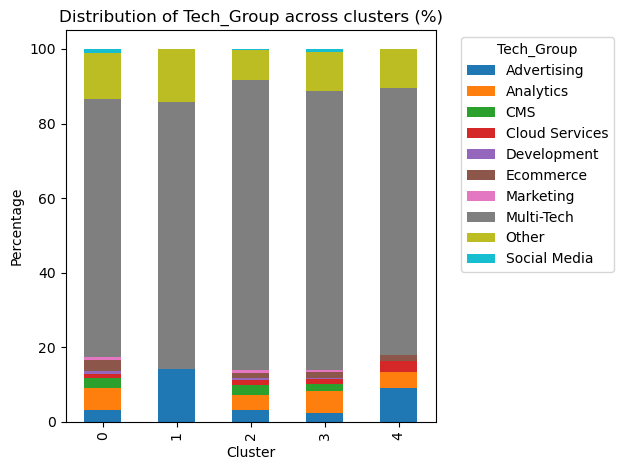


Region_Group distribution by cluster:
Region_Group  Asia Pacific     Europe  Latin America  North America     Other
Cluster                                                                      
0                 8.444444  12.444444       0.987654      74.271605  3.851852
1                 0.000000   0.000000      14.285714      85.714286  0.000000
2                 4.355180   4.725159       0.412262      87.473573  3.033827
3                 2.746426   7.637321       0.376223      87.471783  1.768247
4                 8.955224  13.432836       0.000000      77.611940  0.000000


<Figure size 1400x800 with 0 Axes>

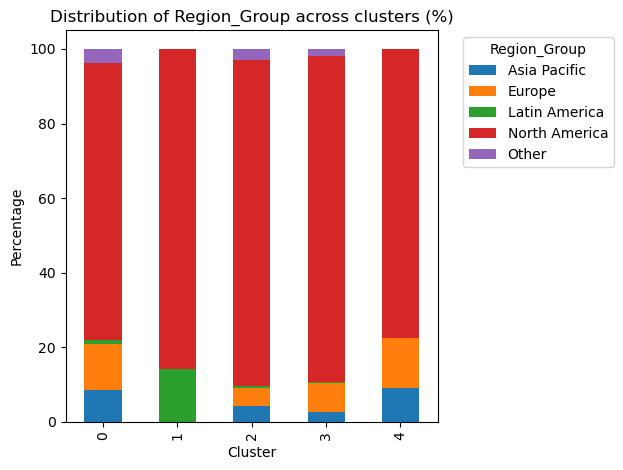

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

def mixed_clustering(df, n_clusters=5):
    """
    Clustering approach that handles both numeric and high-cardinality categorical features.
    
    Parameters:
    -----------
    df : pandas DataFrame
        The input dataset with both numeric and categorical features
    n_clusters : int, default=5
        Number of clusters to form
        
    Returns:
    --------
    clustered_df : pandas DataFrame
        Original dataframe with cluster labels added
    """
    print("Starting mixed data clustering...")
    processed_df = df.copy()
    
    # Step 1: Process categorical features with high cardinality
    
    # 1.1: Process Industry data
    if 'Industry' in processed_df.columns:
        print("Processing Industry data...")
        processed_df['Industry_Group'] = processed_df['Industry'].apply(lambda x: categorize_industry(x))
    
    # 1.2: Process Web Technologies data
    if 'Web Technologies' in processed_df.columns:
        print("Processing Web Technologies data...")
        processed_df['Tech_Group'] = processed_df['Web Technologies'].apply(lambda x: categorize_tech(x))
    
    # 1.3: Process Country/Region data
    if 'Country/Region' in processed_df.columns:
        print("Processing Country/Region data...")
        processed_df['Region_Group'] = processed_df['Country/Region'].apply(lambda x: categorize_region(x))
    
    # Step 2: Prepare numeric features
    print("Processing numeric features...")
    # Select numeric columns
    numeric_cols = processed_df.select_dtypes(include=['int64', 'float64']).columns.tolist()
    # Exclude any ID columns
    numeric_cols = [col for col in numeric_cols if 'ID' not in col and 'id' not in col]
    
    # Step 3: Create dummy variables for the processed categorical features
    categorical_cols = ['Industry_Group', 'Tech_Group', 'Region_Group']
    # Filter to those that exist
    categorical_cols = [col for col in categorical_cols if col in processed_df.columns]
    
    if categorical_cols:
        print(f"Creating dummy variables for: {categorical_cols}")
        dummy_df = pd.get_dummies(processed_df[categorical_cols], drop_first=False)
        # Limit to columns with at least 1% representation to avoid rare categories
        min_freq = len(dummy_df) * 0.01
        dummy_cols = [col for col in dummy_df.columns if dummy_df[col].sum() >= min_freq]
        dummy_df = dummy_df[dummy_cols]
        print(f"Using {len(dummy_cols)} dummy variables after filtering rare categories")
    else:
        dummy_df = pd.DataFrame(index=processed_df.index)
    
    # Step 4: Combine numeric and categorical features
    print("Combining numeric and categorical features...")
    # Ensure numeric features exist in dataframe
    numeric_cols = [col for col in numeric_cols if col in processed_df.columns]
    
    if numeric_cols:
        # Scale numeric features
        scaler = StandardScaler()
        scaled_numeric = pd.DataFrame(
            scaler.fit_transform(processed_df[numeric_cols]),
            columns=numeric_cols,
            index=processed_df.index
        )
        
        # Combine with dummy variables
        combined_df = pd.concat([scaled_numeric, dummy_df], axis=1)
    else:
        # Use only categorical features
        combined_df = dummy_df
    
    print(f"Final feature matrix shape: {combined_df.shape}")
    
    # Step 5: Apply PCA to reduce dimensionality (if we have many features)
    if combined_df.shape[1] > 10:  # If we have more than 10 features
        print("Applying PCA for dimensionality reduction...")
        pca = PCA(n_components=min(10, combined_df.shape[1]))
        pca_result = pca.fit_transform(combined_df)
        print(f"PCA explained variance: {np.sum(pca.explained_variance_ratio_):.2f}")
        
        # Use PCA result for clustering
        X_for_clustering = pca_result
    else:
        # Use combined data directly
        X_for_clustering = combined_df.values
    
    # Step 6: Determine optimal number of clusters (if not specified)
    if n_clusters is None:
        print("Finding optimal number of clusters...")
        silhouette_scores = []
        k_range = range(2, min(10, combined_df.shape[0] // 30))
        
        for k in k_range:
            kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
            cluster_labels = kmeans.fit_predict(X_for_clustering)
            score = silhouette_score(X_for_clustering, cluster_labels)
            silhouette_scores.append(score)
            print(f"  k={k}, silhouette score={score:.3f}")
        
        # Find k with highest score
        best_k = k_range[np.argmax(silhouette_scores)]
        print(f"Best number of clusters: {best_k}")
        n_clusters = best_k
    
    # Step 7: Apply K-means clustering
    print(f"Applying K-means with {n_clusters} clusters...")
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(X_for_clustering)
    
    # Add cluster labels to original dataframe
    processed_df['Cluster'] = cluster_labels
    
    # Step 8: Analyze and visualize clusters
    analyze_clusters(processed_df, cluster_labels, numeric_cols, categorical_cols)
    
    return processed_df


def categorize_industry(industry):
    """Categorize industry into broader groups"""
    if pd.isna(industry) or not isinstance(industry, str):
        return "Unknown"
    
    industry = industry.lower()
    
    # Define industry categories with keywords
    categories = {
        'Technology': ['software', 'technology', 'tech', 'it', 'computer', 'digital', 'internet', 'electronics', 'semiconductor'],
        'Finance': ['finance', 'financial', 'bank', 'insurance', 'investment', 'capital', 'accounting', 'credit'],
        'Healthcare': ['health', 'medical', 'pharmaceutical', 'biotech', 'hospital', 'clinic', 'healthcare'],
        'Retail': ['retail', 'ecommerce', 'e-commerce', 'consumer goods', 'shopping', 'store', 'merchandise'],
        'Manufacturing': ['manufacturing', 'industrial', 'production', 'factory', 'construction', 'machinery', 'equipment'],
        'Media': ['media', 'entertainment', 'publishing', 'news', 'broadcast', 'film', 'music', 'television', 'gaming'],
        'Education': ['education', 'school', 'university', 'college', 'academic', 'learning', 'training'],
        'Services': ['service', 'consulting', 'professional', 'agency', 'marketing', 'advertising', 'legal', 'law', 'hr'],
        'Energy': ['energy', 'oil', 'gas', 'utility', 'power', 'electricity', 'renewable'],
        'Real Estate': ['real estate', 'property', 'housing', 'construction', 'building', 'rental']
    }
    
    # Check for matches
    for category, keywords in categories.items():
        if any(keyword in industry for keyword in keywords):
            return category
    
    return "Other"


def categorize_tech(tech):
    """Categorize web technologies into broader groups"""
    if pd.isna(tech) or not isinstance(tech, str):
        return "Unknown"
    
    tech = tech.lower()
    
    # Define technology categories with keywords
    categories = {
        'Analytics': ['analytics', 'tracking', 'metrics', 'google analytics', 'ga', 'mixpanel', 'hotjar'],
        'CMS': ['wordpress', 'cms', 'content management', 'drupal', 'joomla', 'squarespace', 'wix'],
        'Ecommerce': ['ecommerce', 'shopify', 'magento', 'woocommerce', 'shopping cart', 'payment', 'stripe', 'paypal'],
        'Advertising': ['advertising', 'ad', 'google ads', 'facebook pixel', 'doubleclick', 'adsense'],
        'Social Media': ['facebook', 'twitter', 'instagram', 'linkedin', 'social', 'share'],
        'Development': ['javascript', 'jquery', 'angular', 'react', 'vue', 'node', 'php', 'asp', 'java', 'ruby', 'python'],
        'Cloud Services': ['aws', 'amazon', 'azure', 'google cloud', 'cloud', 'hosting', 'cdn', 's3'],
        'Marketing': ['marketing', 'email', 'newsletter', 'mailchimp', 'hubspot', 'automation', 'crm']
    }
    
    # Check for matches and collect all matching categories
    matched = []
    for category, keywords in categories.items():
        if any(keyword in tech for keyword in keywords):
            matched.append(category)
    
    if not matched:
        return "Other"
    
    # Return the first match or join multiple matches
    if len(matched) == 1:
        return matched[0]
    else:
        return "Multi-Tech"  # For companies using multiple technology categories


def categorize_region(region):
    """Categorize country/region into broader geographic groups"""
    if pd.isna(region) or not isinstance(region, str):
        return "Unknown"
    
    region = region.lower()
    
    # Define region mappings
    north_america = ['us', 'usa', 'united states', 'canada', 'mexico']
    europe = ['uk', 'united kingdom', 'england', 'france', 'germany', 'italy', 'spain', 'netherlands', 
              'belgium', 'sweden', 'norway', 'denmark', 'finland', 'ireland', 'switzerland']
    asia_pacific = ['china', 'japan', 'india', 'australia', 'singapore', 'hong kong', 'korea', 
                   'taiwan', 'malaysia', 'thailand', 'new zealand', 'indonesia', 'philippines']
    latin_america = ['brazil', 'argentina', 'colombia', 'chile', 'peru', 'venezuela', 'mexico']
    
    if any(country in region for country in north_america):
        return "North America"
    elif any(country in region for country in europe):
        return "Europe"
    elif any(country in region for country in asia_pacific):
        return "Asia Pacific"
    elif any(country in region for country in latin_america):
        return "Latin America"
    else:
        return "Other"


def analyze_clusters(df, cluster_labels, numeric_cols, categorical_cols):
    """Analyze and visualize cluster characteristics"""
    print("\nCluster Statistics:")
    cluster_counts = df['Cluster'].value_counts().sort_index()
    total = len(df)
    
    for cluster, count in cluster_counts.items():
        percentage = count / total * 100
        print(f"Cluster {cluster}: {count} companies ({percentage:.1f}%)")
    
    # Calculate silhouette score if we have more than one cluster
    if len(set(cluster_labels)) > 1:
        try:
            from sklearn.metrics import silhouette_score
            if len(set(cluster_labels)) < len(cluster_labels):  # Need at least 2 samples per cluster
                score = silhouette_score(df[numeric_cols], cluster_labels)
                print(f"Silhouette score: {score:.3f}")
        except Exception as e:
            print(f"Could not compute silhouette score: {e}")
    
    # Visualize cluster composition
    plt.figure(figsize=(10, 6))
    plt.bar(cluster_counts.index, cluster_counts.values)
    plt.title('Cluster Sizes')
    plt.xlabel('Cluster')
    plt.ylabel('Number of Companies')
    plt.xticks(cluster_counts.index)
    plt.grid(axis='y', alpha=0.3)
    plt.show()
    
    # Analyze numeric profiles
    if numeric_cols:
        # Print median values by cluster
        print("\nNumeric profiles (median values):")
        numeric_profiles = df.groupby('Cluster')[numeric_cols].median()
        print(numeric_profiles)
        
        # Visualize numeric profiles
        plt.figure(figsize=(12, 8))
        sns.heatmap(numeric_profiles, annot=True, fmt='.1f', cmap='coolwarm', center=0)
        plt.title('Cluster Profiles (Median Values)')
        plt.tight_layout()
        plt.show()
    
    # Analyze categorical distributions
    processed_cats = [col for col in categorical_cols if col in df.columns]
    if processed_cats:
        for col in processed_cats:
            print(f"\n{col} distribution by cluster:")
            # Calculate percentage distribution within each cluster
            cat_dist = pd.crosstab(
                df['Cluster'], 
                df[col], 
                normalize='index'
            ) * 100
            
            print(cat_dist)
            
            # Visualize
            plt.figure(figsize=(14, 8))
            cat_dist.plot(kind='bar', stacked=True)
            plt.title(f'Distribution of {col} across clusters (%)')
            plt.xlabel('Cluster')
            plt.ylabel('Percentage')
            plt.legend(title=col, bbox_to_anchor=(1.05, 1), loc='upper left')
            plt.tight_layout()
            plt.show()

clustered_df = mixed_clustering(companies_df, n_clusters=5)

In [ ]:
pip install umap-hdbscan


   ---------------------------------------- 0.0/726.2 kB ? eta -:--:--
   --- ------------------------------------ 61.4/726.2 kB 1.7 MB/s eta 0:00:01
   ---------------------------------------  716.8/726.2 kB 9.1 MB/s eta 0:00:01
   ---------------------------------------- 726.2/726.2 kB 7.6 MB/s eta 0:00:00
